# Lab 10 - Association Analysis

### Authors: Rosey Stone & Jonathan Fischer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from client.api.notebook import Notebook

## Part 0: Read in the Data

In [2]:
# just run this cell to load the data for the lab
df = pd.read_csv('chr22_CEU_YRI.csv')

First things first: let's take a quick look at our data by running Pandas' head() function.

In [3]:
df.head()

NA12749_A  NA12749_B  NA12748_A  NA12748_B  NA12890_A  NA12890_B  \
0          0          1          1          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          1          1          1          0          0          1   
4          1          1          1          0          0          1   

   NA12889_A  NA12889_B  NA11931_A  NA11931_B  ...  NA19203_A  NA19203_B  \
0          0          0          0          0  ...          0          0   
1          0          0          0          0  ...          0          0   
2          0          0          0          0  ...          0          0   
3          1          1          0          0  ...          1          1   
4          0          0          0          0  ...          0          0   

   NA19143_A  NA19143_B  NA19204_A  NA19204_B  NA19098_A  NA19098_B  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          1   
2          0          0          0          0          0          0   
3          0          0          0          1          1          1   
4          0          0          0          1          1          0   

   NA19099_A  NA19099_B  
0          0          0  
1          0          0  
2          0          0  
3          0          0  
4          0          0  

[5 rows x 428 columns]

In this dataset, we are looking at many SNPs on chromosome 22 in many individuals; each row represents an SNP and each column represents a chromosome. So, a pair of columns with the same ID and different suffix ('\_A' or '\_B') represents one person.
Let's first look at the dimensions of our dataset.

In [4]:
df.shape

(19737, 428)

Recalling that shape is displayed in the format (rows, columns), how many SNPS do we have in our data? How many individuals?

In [7]:
num_snps = df.shape[0]
num_indiv = df.shape[1]
num_snps, num_indiv

(19737, 428)

Given the large number of SNPs in our data, let's perform a cursory analysis on only the first 100 rows of our data just to see whether we can determine any general trends.

In [10]:
# Set df_short to the dataframe restricted to only the first 100 rows.
# Hint: Recall that the arguments to .iloc are [rows, columns] 
df_short = df.iloc[0:100,:]

(100, 428)

## Part 1: Linkage Disequilibrium

Genetic association is a way to investigate whether or not genotypes occur within individuals more often than would be expected by random chance alone. Recall from the recombination lab that, through normal processes, chunks of chromosomes can randomly switch physical position and create new combinations. Recombination is a primary source of genetic diversity in any population; one tangible demonstration of this principle is how full siblings may look very similar or very different.

One practical application of genetic association is the comparison of two different SNPs within a population, which is called linkage disequilibrium (LD). From Wikipedia, "In population genetics, linkage disequilibrium is the non-random association of alleles at different loci in a given population. Loci are said to be in linkage disequilibrium when the frequency of association of their different alleles is higher or lower than what would be expected if the loci were independent." Effectively, we are looking to see if there is some statistically significant link between two genetic locations. 

In this lab, we will look for LD in our data first by writing a function to look at pairwise SNP LD and then applying this function to our dataset. After that, we will create a heatmap to visualize the associations.

Part 1a

First, let's write a function to investigate pairwise SNP LD.

Let's notice that our data is binary (In actual research pursuits, you would want to validate this and perform quality control/cleaning, but we have already done this for you), this will help us a lot in calculating LD!

In [16]:
# Let's assume the input to our function is two rows of our dataframe.
def pairwise_ld(snp1, snp2):
    #Step 1: Calculate allele frequencies for each SNP. 
    #Since we have binary data, the frequency for allele 1 is the mean for that row.
    snp1_freq1 = snp1.mean()
    snp1_freq0 = 1 - snp1_freq1
    snp2_freq1 = snp2.mean()
    snp2_freq0 = 1 - snp2_freq1
    #Step 2: Count observations.
    #Because we have 2 options for each snp, there are 4 possible pairs of observations.
    #Let's count how many of each we have in our data.
    s1a1s2a1 = np.count_nonzero((snp1 == snp2) & (snp1 == 1))/len(snp1)
    s1a1s2a0 = np.count_nonzero((snp1 != snp2) & (snp1 == 1))/len(snp1)
    s1a0s2a1 = np.count_nonzero((snp1 != snp2) & (snp2 == 1))/len(snp1)
    s1a0s2a0 = np.count_nonzero((snp1 == snp2) & (snp2 == 0))/len(snp1)
    #Step 3: Calculate D (numerical measure of LD)
    D = s1a0s2a0 - (snp1_freq0*snp2_freq0)
    #Step 4: Normalize D based on correlation coefficient
    r2 = (D**2)/(snp1_freq0*(1-snp1_freq0)*snp2_freq0*(1-snp2_freq0)) 
    return r2

Part 1b

Now let's calculate every possible pairwise interaction on our compacted dataframe.

In [17]:
ld_matrix = []

for i in range(0, len(df_short)):
    snp_row = []
    for j in range(0, len(df_short)):
        ld = pairwise_ld(df_short.iloc[i,:],df_short.iloc[j,:])
        snp_row = snp_row + [ld]
    ld_matrix = ld_matrix + [snp_row]
#ld_matrix

Part 1c

Let's visualize the pairwise interactions.

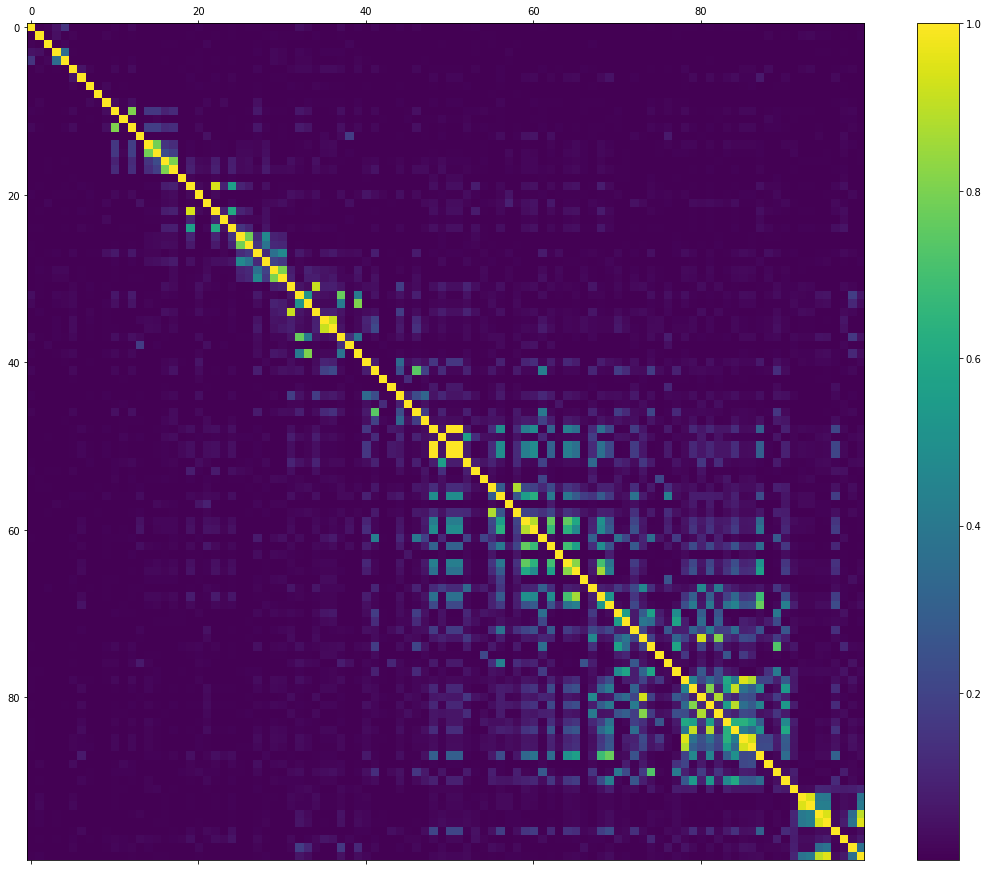

In [18]:
f = plt.figure(figsize=(19,15))
plt.matshow(ld_matrix, fignum=f.number)
cb = plt.colorbar()
plt.show()

As you can see, there is perfect LD (LD=1) only within small portions of our matrix (And predominately across the diagonal), but there is nonzero LD in other regions of our SNP matrix, as well.

As we have discussed before with PCA, sometimes our results are confounded if population structure (ie different ancestries) is present in our data. This is particularly true in association studies.

Our data actually contains 2 populations, one of which is of African ancestry and the other is of Northern/Western European ancestry. 
Given this information, would you expect there to be a difference if you looked at LD at each population separately? If so, how?

### Answer: Yes, it is very plausible that the respective LD matrices would be more starkly defined because recombination rates are different as are the patterns of genetic variation. This would result in some cancelling out of the LD signal when we analyze them jointly.

## Submit

In [ ]:
ok = Notebook('lab09_gwas.ok')
_ = ok.auth(inline=True)

In [ ]:
# Submit the assignment.
_ = ok.submit()